<a href="https://colab.research.google.com/github/PosgradoMNA/TC5035.10.Equipo6/blob/main/Avance2_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

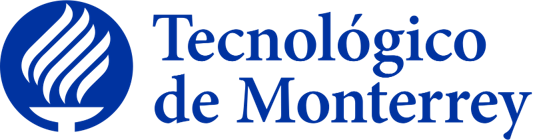

---
# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### **Desarrollo de un Sistema de Visión mediante OpenCV para el Aseguramiento de la Calidad Final de Motores para Aplicaciones Robóticas**
### Profesora Titular: Dra. Grettel Barceló Alonso
### Profesor Titular: Dr. Luis Eduardo Falcón Morales
### Profesor Tutor: María De La Paz Rico Fernández
### Actividad: Avance 2 - Ingeniería de Características
###Alumnos:
* A01793672 - Freddy Armendariz Herrera
* A01793668 - Samuel Elías Flores González
* A01793814 - Emerson Jonathan Rincón Morales
---

##**Importación de Librerías**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import imutils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Carga de Imagen de Referencia y de la Captura**



In [ ]:
# Asignacion de ruta de las imagenes
GoodSample = '/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador/Imagenes/Ref.jpg'
BadSample = '/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador/Imagenes/NoScrews.jpg'

# Lectura de Imagenes
i1 = cv2.imread(GoodSample, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(i1, cv2.COLOR_BGR2RGB)
i2 = cv2.imread(BadSample, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(i2, cv2.COLOR_BGR2RGB)

## **Mostrar Imágenes**

In [ ]:
#Define funcion para mostar imagen
def ShowImages(pictures,titles,x,y):

  qty = len(pictures)                                          #qty = Cantidad de imagenes en la lista de imagenes
  fig = plt.figure(figsize=(x, y))                             #fig = crea figura con dimension x, y

  #Itera las imagenes y los titulos para anexarlos a figura
  for i, (img,tit) in enumerate(zip(pictures,titles)):
    a = fig.add_subplot(1,qty,i+1)                             #a = Agrega subplot
    imgplot = plt.imshow(img, cmap="gray")                     #Muestra imagen en escala de grises
    a.set_title(tit)                                           #Establece titulo

  #Muestra figura con imagenes y titulos
  plt.show()

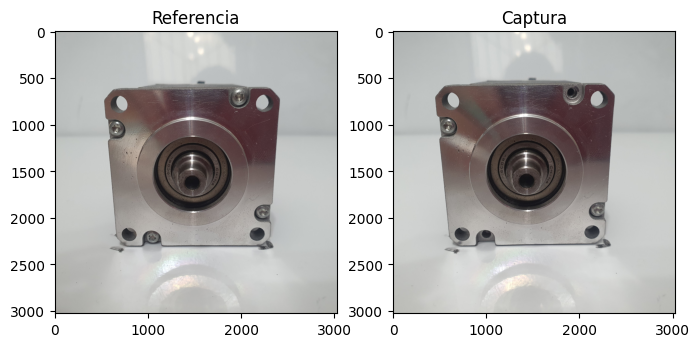

In [ ]:
pics = []                                                      #Se crea lista de imagenes
tits = []                                                      #Se crea lista de titulos

pics.append(im1)                                           #Se agrega imagen al listado de imagenes
tits.append('Referencia')                                      #Se agrega titulo al listado de titulos
pics.append(im2)
tits.append('Captura')

ShowImages(pics,tits,8,16)                                      #Se crea figura usando la imagen de un motor considerado como bueno

## **Características de Imagen y Alineación**

La imagen de referencia es la que se tomará como una muestra buena (golden sample), mientras que la Captura es la imagenes que se desea comparar.

Se puede apreciar que en la Captura, el marco del motor tiene ausencia de 2 de los tornillos del marco (uno de ellos en la esquina superior derecha y otro en la esquina inferior izquierda). También se puede notar que en la Captura, la perspectiva del motor es diferente y no se encuentra alineado de la misma manera que en la Referencia.

Esto se debe a que la imagen nunca será tomada exactamente en el mismo lugar debido a la posición de la cámara, del motor en el fixture en que vaya a ser colocado, etc.

A lo anterior se le llama homografía, en donde un cuadrado es transformado en un cuadro arbitrario.

Lo anterior debe tomarse en cuenta ya que al realizar la sustracción de la imagen, también se apreciará la desalineación del motor en ambas imágenes y no solo los tornillos ausentes.

Por lo tanto, se requiere calcular la homografía para corregir la imagen desalineada, para ello se necesitan mínimo de 4 puntos similares en ambas imágenes. Estos puntos se pueden obtener mediante una extracción de características en ambas imágenes.

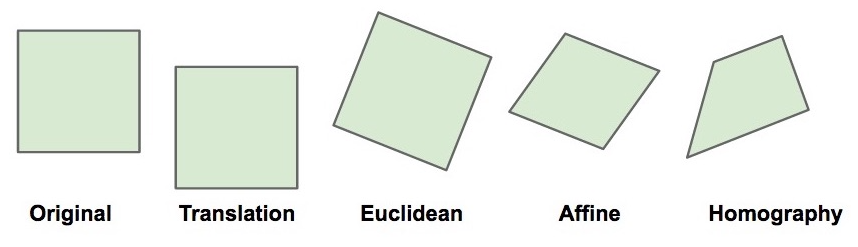

### **Busqueda de Keypoints en Ambas Imágenes**

La extracción de características nos permitirá encontrar las partes más importantes o significativas de la imagen. Para ello haremos uso de un algoritmo que nos permita realizarlo, dentro de los cuales podemos encontrar en OpenCV:


* Scale-Invariant Feature Transform (SIFT):

Considerado el más “robusto” de los 3 algoritmos. Este algoritmo es invariante a escala, rotación, iluminación. En cuanto a velocidad, es mas lento que SURF y ORB.


* Speeded Up Robust Feature (SURF):

Algoritmo creado como mejora de SIFT. Este algoritmo tiene un desempeño similar a SURF pero con un tiempo de ejecución menor a este último debido a que los puntos de interés de SIFT contienen menos descriptores. Es uno de los métodos mas usados para la extracción de características en imágenes.


* Orientated FAST and Robust BRIEF (ORB):

Basado en un detector FAST y el descriptor BRIEF, este algoritmo es más eficiente computacionalmente que SIFT y SURF. Debido a su velocidad es mas adecuado para aplicaciones ejecutadas en tiempo real. Este algoritmo da prioridad a la eficiencia computacional y sacrifica un poco la precisión de detección y descripción de caracteristicas.



*   **Selección:**


Para este caso en particular las variaciones entre las imágenes, si bien no están en la posición exacta en todos los casos, no es considerable, variando unos cuantos milímetros y unos pocos grados el punto donde se tomará la imagen para la inspección visual así que no es tan necesario de un algoritmo tan preciso. Adicionalmente, nuestra aplicación requiere que el algoritmo empleado sea eficiente, debido a que El procesamiento de la imagen debe ser relativamente rápida, para brindar una respuesta sobre si el componente inspeccionado en cuestión es aceptable o no por el estándar de calidad.
Debido a estas razones se ha escogido ORB para la extracción de características.



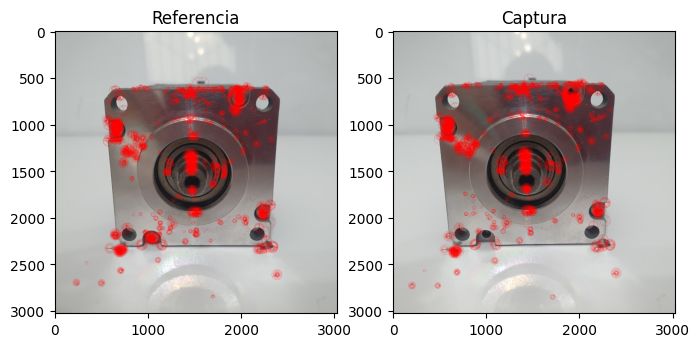

In [ ]:
# Conversion de imagenes a escala de grises
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Deteccion de caracteristicas ORB y descriptores.
MAX_NUM_FEATURES = 3000
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Dibujar caracteristicas sobre imagenes originales
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Mostrar Imagenes con keypoints
pics = []
tits = []

pics.append(im1_display)
tits.append('Referencia')
pics.append(im2_display)
tits.append('Captura')

ShowImages(pics,tits,8,16)

Cada uno de los círculos rojos es una característica que define a la imagen en cuestion.

### **Emparejamiento de Keypoints en Ambas Imagenes**

Se comparan los descriptores de los keypoints obtenidos de ambas imágenes para encontrar la correspondencia.

Para los descriptores SIFT y SURF se puede utilizar el método de distancia Euclidiana. Sin embargo, para nuestro caso, al haber usado ORB (cadenas binarias), se usará la distancia de Hamming.

La distancia de Hamming hace una comparación entre dos cadenas binarias, tomando en cuenta la cantidad de posiciones en la que los bits correspondientes son diferentes. Por ejemplo, en la siguiente ilustración las cadenas binarias difieren entre si en las posiciones 1, 3 y 5. Dando como resultado 3 bits diferentes.


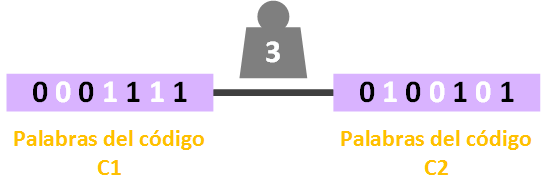

In [ ]:
# Emparejamiento de características.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Se convierte a lista debido a que las tuplas son objetos inmutables.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Se ordenan los emparejamientos por puntaje.
matches.sort(key=lambda x: x.distance, reverse=False)

# Los emparejamientos no tan buenos son removidos.
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

Text(0.5, 1.0, 'Emparejamientos')

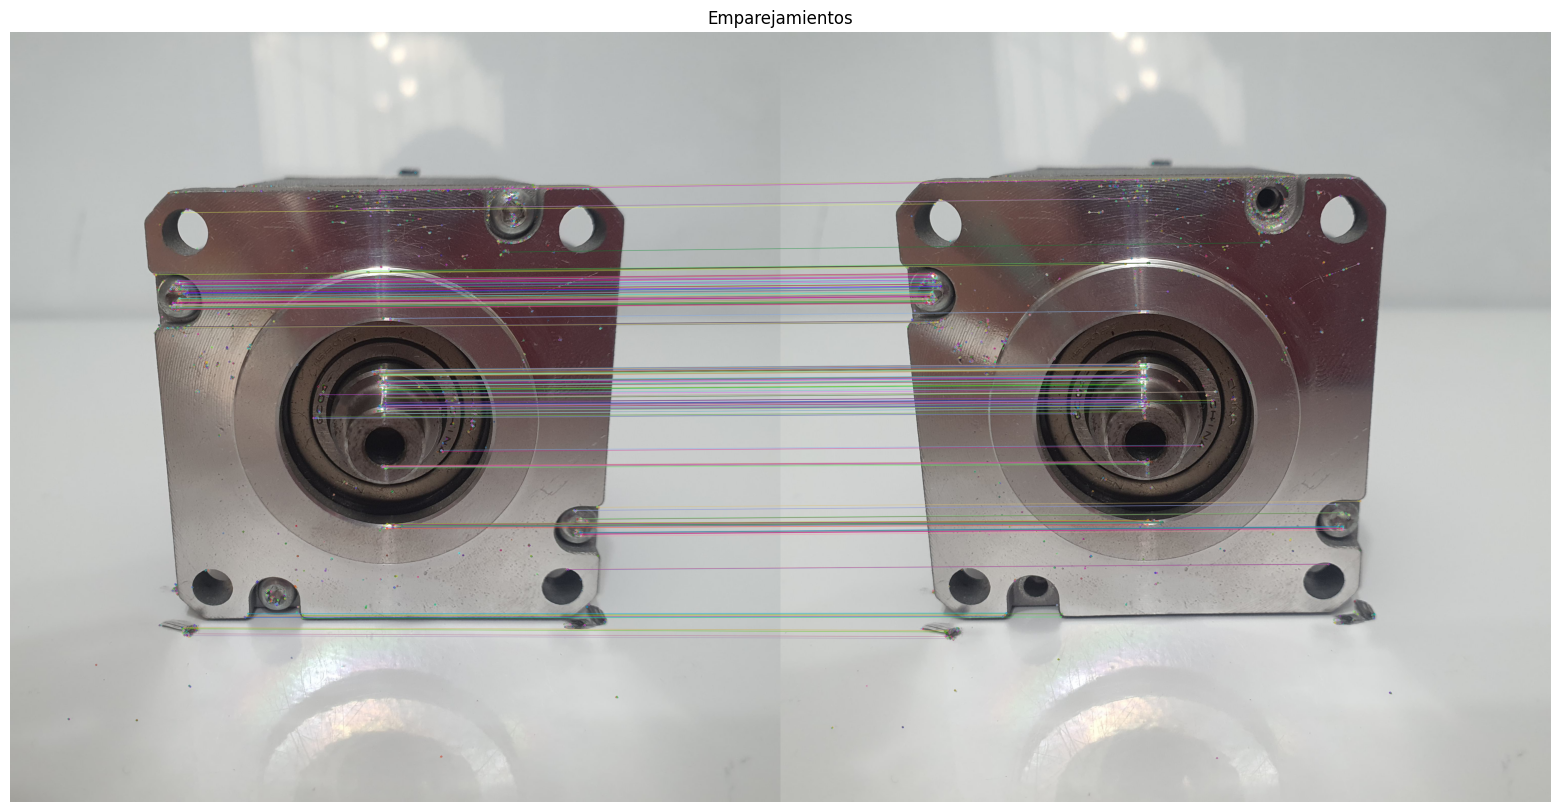

In [ ]:
# Se dibujan los emparejamientos
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(im_matches);plt.axis("off");plt.title("Emparejamientos")

### **Encontrar Homografía**

In [ ]:
# Extraer ubicacion de emparejamientos buenos
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Encontrar homografia
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

### **Corrección de Imagen**

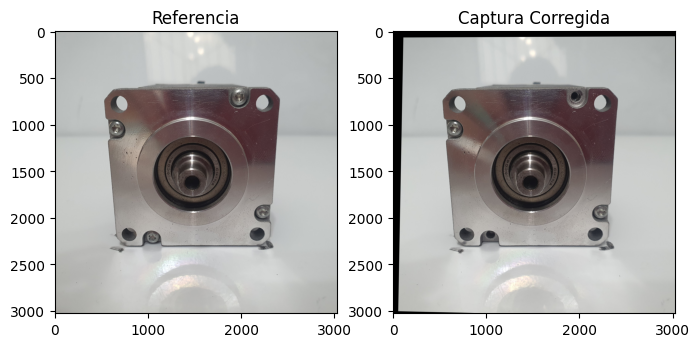

In [ ]:
# Usar homografía para corregir imagen
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))

# Mostrar Imagenes
pics = []
tits = []

pics.append(im1)
tits.append('Referencia')
pics.append(im2_reg)
tits.append('Captura Corregida')

ShowImages(pics,tits,8,16)

## **Región de Interés**

Como su nombre lo indica, la región de interés tiene la función de habilitar únicamente la zona de la imagen en la que se tiene interés para facilitar su futuro procesamiento.
En este caso, la región de interés se colocará sobre la posición donde se supone debe estar ubicado uno de los tornillos.

### **Creación de Polígono en Blanco**

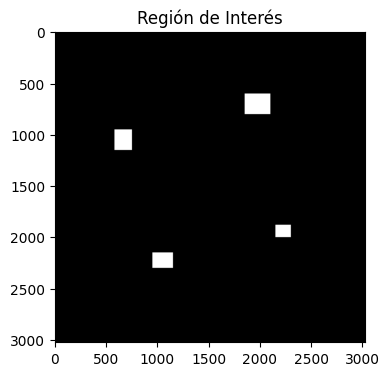

In [ ]:
# Imagenes convertidas a escala de grises
gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(im2_reg, cv2.COLOR_BGR2GRAY)

# Definicion de Region de Interes Arbitraria
vertices1 = np.array([[(1850,800),(1850,600),(2100,600),(2100,800)]], dtype=np.int32)
vertices2 = np.array([[(950,2300),(950,2150),(1150,2150),(1150,2300)]], dtype=np.int32)
vertices3 = np.array([[(580,1150),(580,950),(750,950),(750,1150)]], dtype=np.int32)
vertices4 = np.array([[(2150,2000),(2150,1880),(2300,1880),(2300,2000)]], dtype=np.int32)

# Imagen en Negro con las mismas dimensiones de la imagen de referencia
roi_img = np.zeros_like(gray1)

# Dibujar ROI sobre imagen en negro
cv2.fillPoly(roi_img, vertices1, 255)
cv2.fillPoly(roi_img, vertices2, 255)
cv2.fillPoly(roi_img, vertices3, 255)
cv2.fillPoly(roi_img, vertices4, 255)

# Mostrar ROI
pics = []
tits = []

pics.append(roi_img)
tits.append('Región de Interés')

ShowImages(pics,tits,4,16)

### **Operación AND entre Imagen con ROI e Imagenes en Escala de Grises**

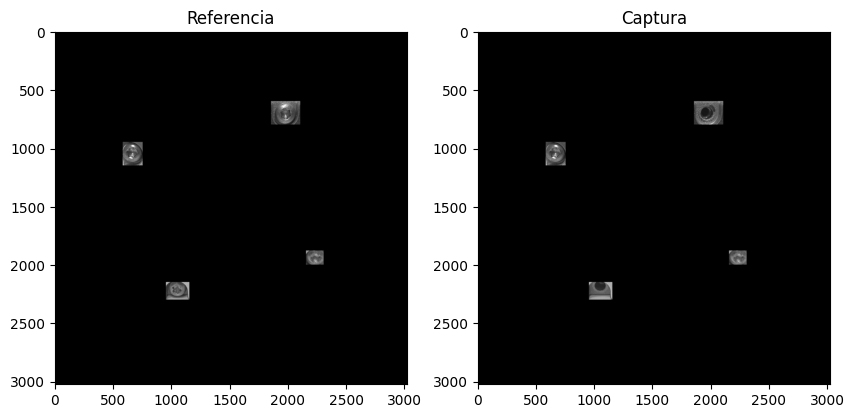

In [ ]:
# Aplicación de Operación AND
im1_roi = cv2.bitwise_and(gray1, roi_img)
im2_reg_roi = cv2.bitwise_and(gray2, roi_img)

# Mostrar Imagenes
pics = []
tits = []

pics.append(im1_roi)
tits.append('Referencia')
pics.append(im2_reg_roi)
tits.append('Captura')

ShowImages(pics,tits,10,16)

Se puede apreciar como la región de interés solo deja mostrada la zona en donde se posiciona un tornillo.

## **Sustracción de Diferencias**

La sustracción de diferencias es aplicada sobre las imágenes obtenidas en el paso anterior, es decir, sobre las imágenes en donde la región de interés ha sido aplicada. Esto es para que la diferencia sea más precisa y notoria.

In [ ]:
img_height = im1_roi.shape[0]

### **Encontrar Diferencia entre Ambas Imágenes**

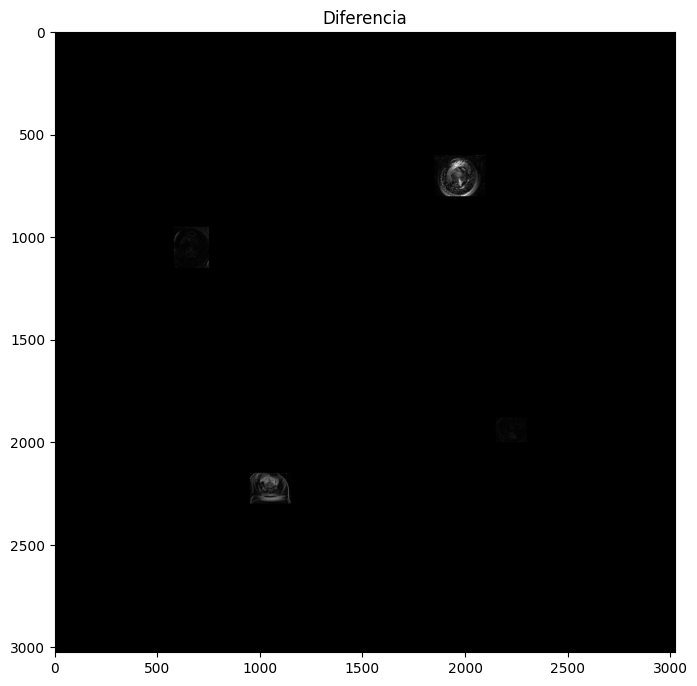

In [ ]:
# Calcular diferencia absoluta entre los dos arreglos
diff = cv2.absdiff(im1_roi, im2_reg_roi)

# Mostrar Diferencia
pics = []
tits = []

pics.append(diff)
tits.append('Diferencia')

ShowImages(pics,tits,8,16)

Se puede notar que la diferencia entre ambas imágenes es la cabeza del tornillo.

### **Aplicación de Segmentación**

Se procede a realizar una segmentación para que la imagen quede binarizada y que así la diferencia sea aún más notoria.

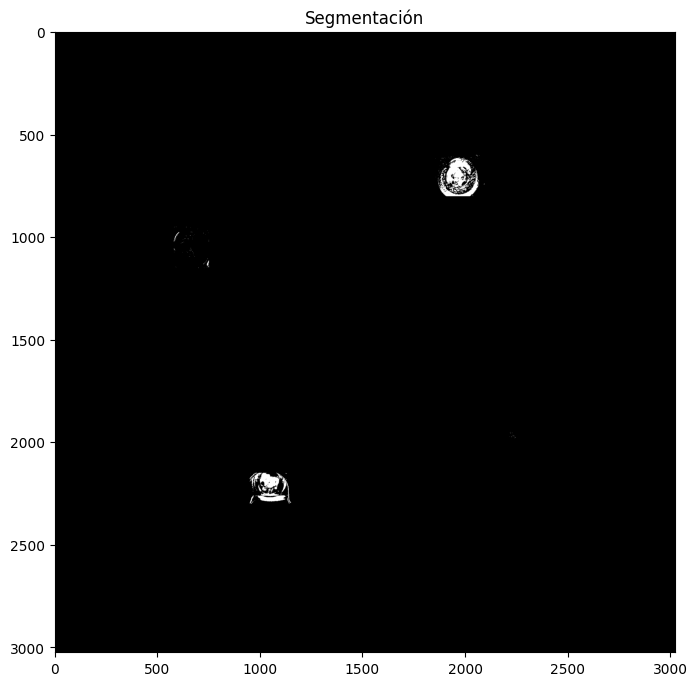

In [ ]:
# Se aplican THRESH_BINARY y THRESH_OTSU
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Mostrar Imagen Segmentada
pics = []
tits = []

pics.append(thresh)
tits.append('Segmentación')

ShowImages(pics,tits,8,16)

### **Aplicación de Dilatación**

En este caso, la dilatación se aplica para eliminar las particulas negras dentro de la cabeza del tornillo y dejar en blanco toda esa zona.

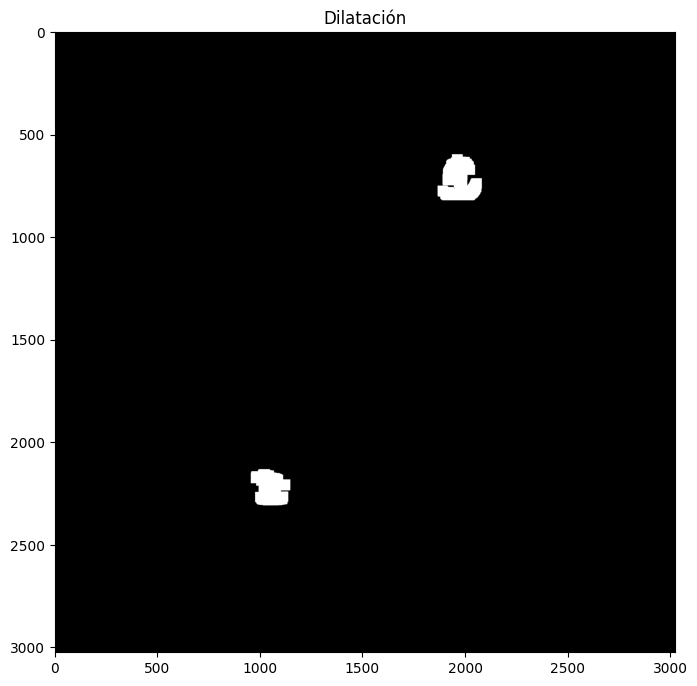

In [ ]:
# Dilatación
kernel1 = np.ones((25,25), np.uint8)
kernel2 = np.ones((10,10), np.uint8)
erosion = cv2.erode(thresh, kernel2, iterations=1)
dilate = cv2.dilate(erosion, kernel1, iterations=2)

# Mostrar Imagen Dilatada
pics = []
tits = []

pics.append(dilate)
tits.append('Dilatación')

ShowImages(pics,tits,8,16)

### **Cálculo de Contornos**

In [ ]:
# Calcular Contornos
contours = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

for contour in contours:
    if cv2.contourArea(contour) > 100:
        # Calcular marco alrededor de los contornos
        x, y, w, h = cv2.boundingRect(contour)
        # Dibujar marcos en ambas imagenes
        cv2.rectangle(im1, (x, y), (x+w, y+h), (255,0,0), 10)
        cv2.rectangle(im2_reg, (x, y), (x+w, y+h), (255,0,0), 10)

### **Visualización de Imágenes con Marcos en las Diferencias**

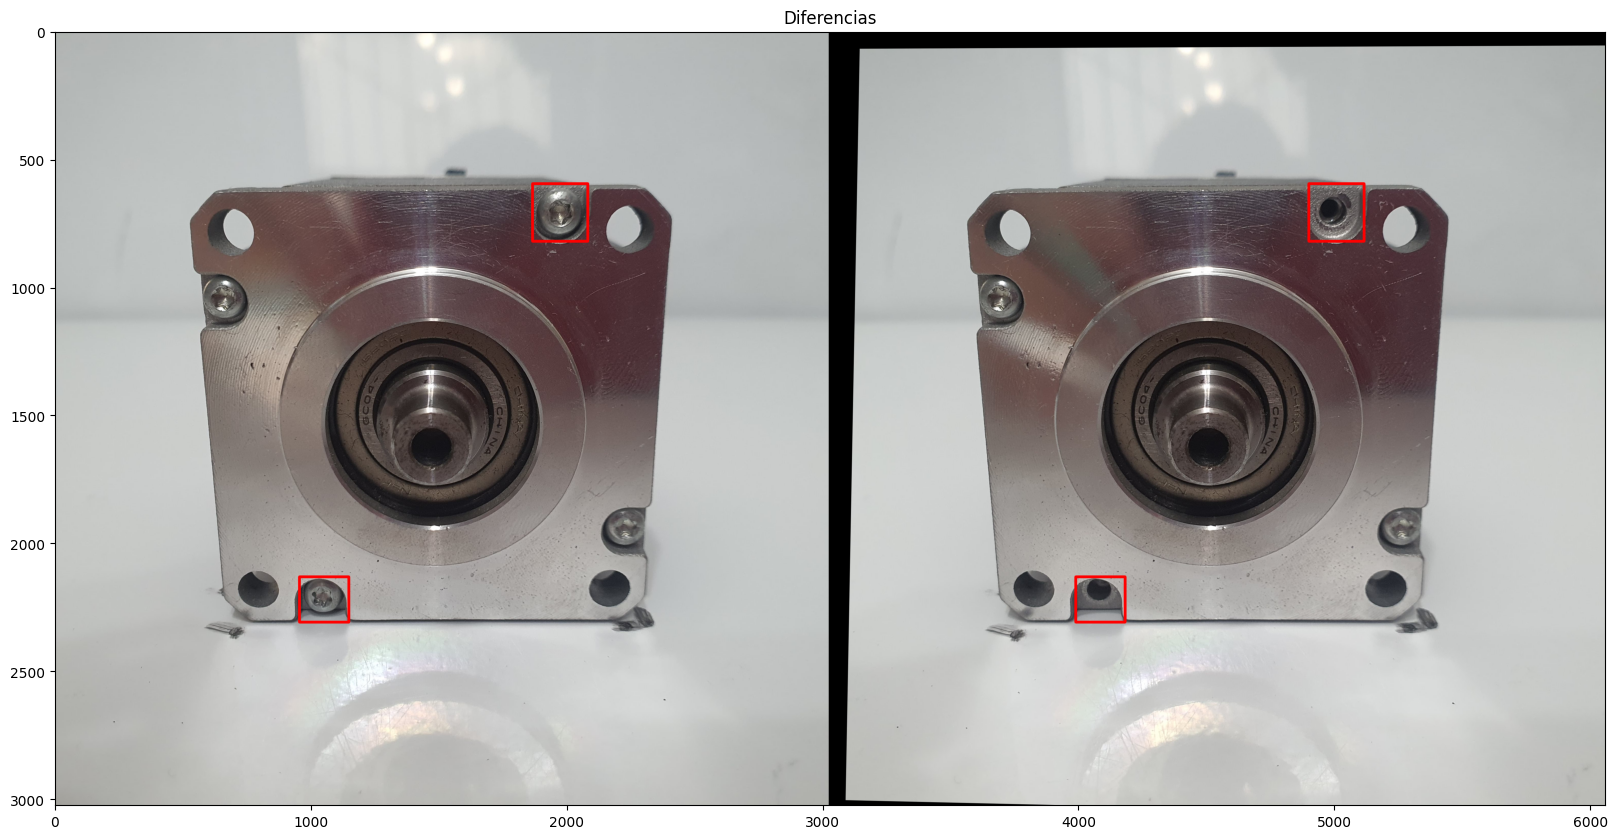

In [ ]:
# Mostrar Imagenes con rectangulos señalando las diferencias
x = np.zeros((img_height,10,3), np.uint8)
result = np.hstack((im1, x, im2_reg))

# Mostrar Imagen Dilatada
pics = []
tits = []
pics.append(result)
tits.append('Diferencias')
ShowImages(pics,tits,20,20)

cv2.waitKey(0)
cv2.destroyAllWindows()

Se puede observar como las diferencias radican principalmente en donde hay ausencia de tornillos y estos son identificados con un recuadro rojo.

### **Obtener Error MSE**

Entre más chico, mejor: En muchos casos, especialmente en la comparación de imágenes, un error más pequeño indica que las imágenes son más similares entre sí. Por lo tanto, un valor de MSE más bajo indicaría que las dos imágenes son más compatibles o que tienen menos diferencias.

In [ ]:
# Definicion de funcion para calcular MSE entre las dos imagenes
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse, diff

error, diff = mse(im1_roi, im2_reg_roi)
print("Error de compatibilidad entre las dos imagenes:",error)

Error de compatibilidad entre las dos imagenes: 0.49066594230284705


Se puede tomar el valor de erro de MSE como bandera al definir límites sobre este valor y así determinar si la evaluación del objeto en cuestión es buena o mala, tener un valor de 0 en MSE supone una comparación idéntica entre ambas imágenes.

## **Bibliografía**

* Checking images for similarity with OpenCV. (s. f.). Stack Overflow. https://stackoverflow.com/questions/11541154/checking-images-for-similarity-with-opencv
* How to compare two images in OpenCV Python? (s. f.). https://www.tutorialspoint.com/how-to-compare-two-images-in-opencv-python#:~:text=To%20compare%20two%20images%2C%20we,width%20and%20number%20of%20channels
* Kostasthanos. (s. f.). GitHub - kostasthanos/Spot-The-Differences: Spot the differences between two images using Python and OpenCV. GitHub. https://github.com/kostasthanos/Spot-The-Differences?tab=readme-ov-file
* OpenCV University. (2023, 3 abril). Image Features & Alignment with OpenCV [Vídeo]. YouTube. https://www.youtube.com/watch?v=_o6fSMCmNnQ
* Using OpenCV for Image Similarity. (2021, 26 noviembre). OpenCV. https://forum.opencv.org/t/using-opencv-for-image-similarity/6444